In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from acoustools.BEM import load_scatterer, get_cache_or_compute_H, propagate_BEM_pressure, compute_E
from acoustools.Utilities import create_points, TOP_BOARD
from acoustools.Solvers import wgs
import csv

In [5]:
# Parameters
n = 6  # Number of traps (n-gon)
r = 0.05  # Radius of n-gon
heights = np.linspace(1, 10, 10)  # Heights at which to evaluate pressure
path = "C:/Users/Abdullah Saeed/Documents/BEMMedia"
csv_name = "height_test_data.csv"
board = TOP_BOARD

# Load reflector
reflector_type_names = ["flat", "Nonflat"] # stl files should be in format "{name}-lam{i}.stl" - store name here
lambda_start = 1 # lowest i value for stl files
lambda_end = 2 # highest i value for stl files

In [7]:
# Create empty CSV file or clear existing one
with open(csv_name, mode="w", newline="") as file:
    pass

pressures = []
for reflector_type in reflector_type_names:
    # print(f"Reflector type: {reflector_type}")
    pressure_type = []

    # List of all .stl file names for loading scatterer
    path_list = [f"/{reflector_type}-lam{i}.stl" for i in range(lambda_start, lambda_end+1)]

    for reflector_path in path_list:
        reflector = load_scatterer(path+reflector_path, dz=-0.05)
        pressure_list = []

        H = get_cache_or_compute_H(reflector,TOP_BOARD,path=path)

        for current_height in heights:
            # print(f"Height: {current_height}")

            # Calculate coordinates for n points in a circle around 0,0
            angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
            trap_points = torch.tensor([[r * np.cos(a), r * np.sin(a), current_height] for a in angles], dtype=torch.float32)

            xs = []
            ys = []
            zs = []
            for p in trap_points:
                xs.append(p[0])
                ys.append(p[1])
                zs.append(p[2])
            
            # Create points
            p = create_points(N=1, B=1, x=xs,y=ys,z=zs)
            E = compute_E(reflector,points=p,board=TOP_BOARD,path=path,H=H)
            xs = wgs(p,A=E)

            # Compute pressure at the trap locations and store average for plotting
            pressure = propagate_BEM_pressure(xs, p, reflector, TOP_BOARD, path=path, H=H)
            average_pressure = pressure.mean()
            pressure_list.append(average_pressure)

            # Store pressures in CSV
            with open(csv_name, mode="a", newline="") as file:
                writer = csv.writer(file)
                
                # Write each row with format: stl_name, height, n, pressure1, pressure2, ...
                # print(pressure)
                clean_pressures = pressure.view(-1).tolist()
                writer.writerow([reflector_path, current_height, n] + clean_pressures)
                
        pressure_type.append(pressure_list)
    pressures.append(pressure_type)

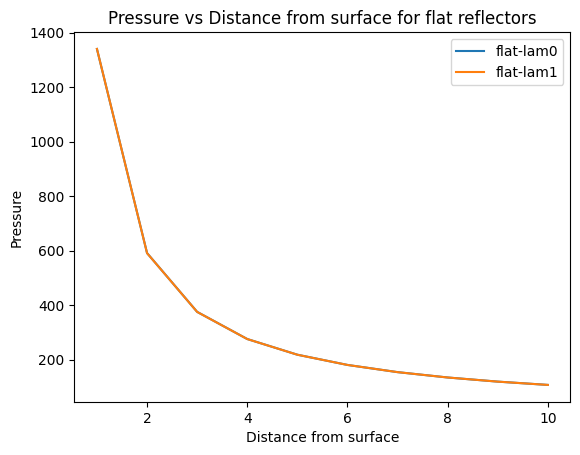

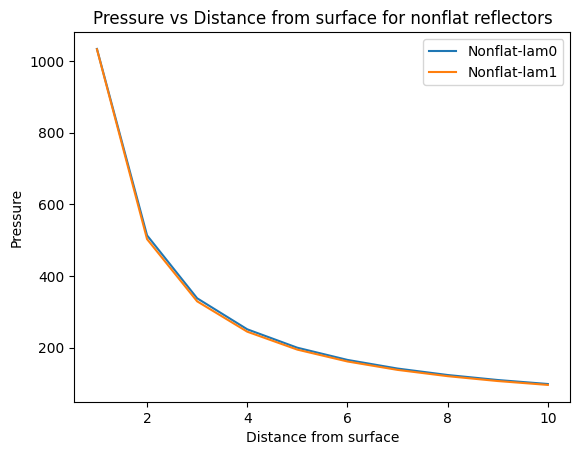

In [8]:
# Plot height against pressure graph for each type of reflector
i = 0 # index for reflector type name
for type in pressures:
    # print(type)
    fig, ax = plt.subplots()
    clean_pressures = [[float(val) for val in row] for row in type]
    for j, pressure_list in enumerate(clean_pressures):
        ax.plot(heights, pressure_list, label=f"{reflector_type_names[i]}-lam{j}")
    ax.legend()
    plt.xlabel("Distance from surface")
    plt.ylabel("Pressure")
    plt.title(f"Pressure vs Distance from surface for {reflector_type_names[i].lower()} reflectors")
    plt.show()
    i += 1